# Building a Multi-agent-RAG Bot for Specialized Question-Answering**

The system starts with a **[Query Router](#query-routing-with-langgraph)**, which receives the user query and directs it to the appropriate agent based on the query type. The agents include:
- **[CSV Agent](#csv-agent-handling-car-data)**: Handles car-related queries using structured data.
- **[Markdown Agent](#markdown-agent-handling-country-data)**: Manages country-related queries using unstructured markdown data.
- **[Math Agent](#math-agent-handling-mathematical-queries)**: Processes mathematical queries.
- **[Fallback Handling](#out-of-scope-query-handling)**: If the query does not match any category, the system informs the user that the query is out of scope.

Add *environment variables* to **.env** file:
   - `GROQ_API_KEY=<Groq chat api key>`
   - `LANGSMITH_TRACING=true` (Optional) To see and debug the trace of every agent
   - `LANGSMITH_ENDPOINT=https://api.smith.langchain.com` (Optional)
   - `LANGSMITH_API_KEY=<LangSmith API Key>` (Optional)
   - `LANGSMITH_PROJECT=<Trace project>` (Optional)

In [2]:
from dotenv import load_dotenv
load_dotenv()

COUNTRY_VECTOR_DB = "./country_vector_db"
COUNTRY_COLLECTION = "country_collection"
EMBEDDING_MODEL = "sentence-transformers/all-mpnet-base-v2"
COUNTRY_DATA_MD = "data/country_data.md"
CARS_DATASET_CSV = "data/cars_dataset.csv"
MODEL_NAME = "gemma2-9b-it"
CARS_TABLE = 'cars'
CARS_DB = 'sqlite:///cars.db'

#### Define LangGraph State

In [3]:
from typing import Annotated, Literal, Sequence, Union
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph import END, StateGraph, START
from langgraph.graph.message import AnyMessage, add_messages
from langchain_core.messages import AIMessage, BaseMessage

# Define the state for the agent
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

## **CSV Agent (Handling Car Data)**
- The car data is structured, making it suitable for a **SQL-based retrieval approach**.
- The agent utilizes **table schemas and sample data** to generate SQL queries dynamically.
- A **SQL execution tool** retrieves answers based on these queries.
- **Error Handling**: Implemented mechanisms to catch and suppress errors within the tool execution.
- **Future Improvement**: Some columns, like `Description` and `Other Specifications`, contain unstructured text, making SQL-based querying insufficient. A **vector-based retriever** can be incorporated to improve performance, but this is beyond the current assignment scope.

### Preprocessing (change to SQL Database)

In [4]:
import pandas as pd
df = pd.read_csv(CARS_DATASET_CSV)
# Rename columns by replacing spaces with underscores
df.columns = df.columns.str.replace(" ", "_")
df

,Car_Name,Manufacturer,Launch_Year,Description,Engine_Specifications,Other_Specifications,User_Ratings,NCAP_Global_Rating
0,OffDecision12,Ross PLC,2017,Experience the fusion of style and performance...,"I6, 253 HP, 1520cc","SUV, 10 km/l, 203 km/h top speed",2.5,4
1,ExistGround23,Ross PLC,2017,The ExistGround23 by Ross PLC is a luxurious a...,"Electric, 281 HP, 4515cc","SUV, 15 km/l, 238 km/h top speed",2.1,1
2,SometimesHerself24,Ross PLC,2021,The SometimesHerself24 by Ross PLC is a effici...,"V8, 367 HP, 2351cc","Coupe, 15 km/l, 219 km/h top speed",5.0,1
3,OffAround14,Ross PLC,2006,The OffAround14 by Ross PLC is a elegant and v...,"Electric, 585 HP, 1464cc","Coupe, 12 km/l, 221 km/h top speed",1.7,4
4,PriceIdea77,Ross PLC,2002,"Ross PLC presents the PriceIdea77, a efficient...","V6, 422 HP, 1762cc","Hatchback, 6 km/l, 238 km/h top speed",2.8,2
...,...,...,...,...,...,...,...,...
1995,ApproachWife68,"Adams, Nelson and Taylor",2023,"Adams, Nelson and Taylor presents the Approach...","V6, 324 HP, 2388cc","Coupe, 11 km/l, 113 km/h top speed",2.8,2
1996,"Adams, Nelson and Taylor",ThoughNumber19,2021,"ThoughNumber19 presents the Adams, Nelson and ...","I4, 307 HP, 3055cc","Convertible, 5 km/l, 119 km/h top speed",1.7,5
1997,"Adams, Nelson and Taylor",ProduceThis27,1999,"The Adams, Nelson and Taylor by ProduceThis27 ...","V6, 211 HP, 4787cc","Convertible, 10 km/l, 176 km/h top speed",2.9,1
1998,ConsiderSuffer61,"Adams, Nelson and Taylor",2012,Experience the fusion of style and performance...,"V8, 273 HP, 4048cc","SUV, 11 km/l, 245 km/h top speed",1.0,2


In [5]:
from langchain_community.utilities import SQLDatabase
from sqlalchemy import create_engine

engine = create_engine(CARS_DB)
df.to_sql(CARS_TABLE, engine, if_exists='replace')
db = SQLDatabase(engine=engine)
print("Database dialect ->", db.dialect)
print("Tables -> :", db.get_usable_table_names())

Database dialect -> sqlite
Tables -> : ['cars']


### Utility functions

In [6]:
from typing import Any

from langchain_core.messages import ToolMessage
from langchain_core.runnables import RunnableLambda, RunnableWithFallbacks
from langgraph.prebuilt import ToolNode

def create_tool_node_with_fallback(tools: list) -> RunnableWithFallbacks[Any, dict]:
    """
    Create a ToolNode with a fallback to handle errors and surface them to the agent.
    """
    return ToolNode(tools).with_fallbacks(
        [RunnableLambda(handle_tool_error)], exception_key="error"
    )

def handle_tool_error(state) -> dict:
    error = state.get("error")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"Error: {repr(error)}\n please fix your mistakes.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

In [7]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit
from langchain.chat_models import init_chat_model

llm = init_chat_model(MODEL_NAME, model_provider="groq")

toolkit = SQLDatabaseToolkit(db=db, llm=llm)
tools = toolkit.get_tools()

list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")

print(list_tables_tool.invoke(""))
print(get_schema_tool.invoke("cars"))

cars

CREATE TABLE cars (
	"index" BIGINT, 
	"Car_Name" TEXT, 
	"Manufacturer" TEXT, 
	"Launch_Year" BIGINT, 
	"Description" TEXT, 
	"Engine_Specifications" TEXT, 
	"Other_Specifications" TEXT, 
	"User_Ratings" FLOAT, 
	"NCAP_Global_Rating" BIGINT
)

/*
3 rows from cars table:
index	Car_Name	Manufacturer	Launch_Year	Description	Engine_Specifications	Other_Specifications	User_Ratings	NCAP_Global_Rating
0	OffDecision12	Ross PLC	2017	Experience the fusion of style and performance with the OffDecision12 from Ross PLC. This elegant co	I6, 253 HP, 1520cc	SUV, 10 km/l, 203 km/h top speed	2.5	4
1	ExistGround23	Ross PLC	2017	The ExistGround23 by Ross PLC is a luxurious and agile minivan. It features intuitive user interface	Electric, 281 HP, 4515cc	SUV, 15 km/l, 238 km/h top speed	2.1	1
2	SometimesHerself24	Ross PLC	2021	The SometimesHerself24 by Ross PLC is a efficient and robust coupe. It features unmatched reliabilit	V8, 367 HP, 2351cc	Coupe, 15 km/l, 219 km/h top speed	5.0	1
*/


### Build Agent tools
- Using Groq API with Llama3 models
- Using SQLDatabaseToolkit from Langchain to use some already defined tools

#### Tool '**db_query_tool**' to execute query against database and return results.

In [8]:
from langchain_core.tools import tool

@tool
def db_query_tool(query: str):
    """
    Execute a SQL query against the database and get back the result.
    If the query is not correct, an error message will be returned.
    If an error is returned, rewrite the query, check the query, and try again.
    """
    result = db.run_no_throw(query)
    if not result:
        return "Error: Query failed. Please rewrite your query and try again."
    return result

# print(db_query_tool.invoke("SELECT * FROM cars LIMIT 2;"))

#### Tool '**model_check_query**' to verify the query

In [9]:
from langchain_core.prompts import ChatPromptTemplate
from langchain.chat_models import init_chat_model

query_check_llm = init_chat_model(MODEL_NAME, model_provider="groq", temperature=0)
query_check_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the SQLite query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes, just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
"""

query_check_prompt = ChatPromptTemplate.from_messages(
    [("system", query_check_system_prompt), ("placeholder", "{messages}")]
)
query_check_tool = query_check_prompt | query_check_llm.bind_tools(
    [db_query_tool], tool_choice="required"
)

def model_check_query(state) -> dict[str, list[BaseMessage]]:
    """
    Use this tool to double-check if your query is correct before executing it.
    """
    print(" ------- Inside model_check_query ----- ")
    response = query_check_tool.invoke({"messages": [("system", state["messages"][-1].content)]})
    return {"messages": [response]}

#query_check_tool.invoke({"messages": [("user", "Hello  SELECT * FROM cars LIMIT 10;")]})

#### Tool to get table schema

In [10]:
from langchain.chat_models import init_chat_model
# Add a node for a model to choose the relevant tables based on the question and available tables
model_get_schema = init_chat_model(MODEL_NAME, model_provider="groq", temperature=0).bind_tools(
    [get_schema_tool]
)

#### Final answer node '**query_gen**'

In [11]:
# Describe a tool to represent the end state
class SubmitFinalAnswer(BaseModel):
    """Submit the final answer to the user based on the query results."""

    final_answer: str = Field(..., description="The final answer to the user")


# Add a node for a model to generate a query based on the question and schema
query_gen_system = """You are a SQL expert with a strong attention to detail.
Given an input question, generate a syntactically correct SQLite query to retrieve the answer.

Query Generation Guidelines:
Output only the SQL query—no extra text.
If number of results are not mentioned in the question then limit them to 10.
Order results meaningfully to return the most relevant examples.
If an error occurs, rewrite and retry the query.
If the result set is empty, modify the query to retrieve meaningful data.

Execution Constraints:
Never execute DML statements (INSERT, UPDATE, DELETE, DROP, etc.).
If you receive a schema from sql_db_schema with only sample data, generate a query first before submitting a final answer.

Tools:
Your main aim is to generate a SQL query unless you have been provided with context data from your previous generated query execution.
If you have enough context data dump provided by previous tool to answer the provided question, then you need to frame the final answer and invoke appropriate tool to submit the answer. But if you do not have any context data dump received from the database, and have not generated any SQL query either, do not invoke any tool at all, generate a SQL query.
If after trying multiple times, sufficient data is still not available, state final answer as "I don't have enough information to answer this question", and call appropriate tool to submit this answer."
"""

query_gen_prompt = ChatPromptTemplate.from_messages(
    [("system", query_gen_system), ("placeholder", "{messages}")]
)
query_gen = query_gen_prompt | init_chat_model(MODEL_NAME, model_provider="groq", temperature=0).bind_tools(
    [SubmitFinalAnswer]
)

def query_gen_node(state: State):
    print("-------- Query Gen / SubmitFinalAnswer -------------")
    message = query_gen.invoke(state)

    # Sometimes, the LLM will hallucinate and call the wrong tool. We need to catch this and return an error message.
    tool_messages = []
    if message.tool_calls:
        for tc in message.tool_calls:
            if tc["name"] != "SubmitFinalAnswer" :
                tool_messages.append(
                    ToolMessage(
                        content=f"Error: The wrong tool was called: {tc['name']}. Please fix your mistakes. Remember to only call SubmitFinalAnswer to submit the final answer. Generated queries should be outputted WITHOUT a tool call.",
                        tool_call_id=tc["id"],
                    )
                )
    else:
        tool_messages = []

    if "final_answer" in message:
        return {"messages": [message["final_answer"]]}
    elif "final_answer" in message.content:
        return {"messages": [message["content"]["final_answer"]]}
    return {"messages": [message] + tool_messages}

# query_gen.invoke({"messages": [("user", "What are the latest cars launched?")]})

## **Markdown Agent (Handling Country Data)**
- Uses the **docling** library to extract markdown files and convert them into structured chunks.
- **Header paths** are preserved in each chunk to provide better contextual understanding.
- A **similarity search** mechanism is applied to retrieve relevant chunks.
- Retrieved documents serve as context for generating the final response.


### Load Markdown Documents using *docling*

In [12]:
from langchain_docling import DoclingLoader
loader = DoclingLoader(file_path=COUNTRY_DATA_MD)
docs = loader.load()
# Each document split has header data associated with them
print(docs[6].page_content)

/Users/ssdn/PycharmProjects/multi-agent-rag/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Token indices sequence length is longer than the specified maximum sequence length for this model (573 > 512). Running this sequence through the model will result in indexing errors


Country: London
About the Country best play:
In Milan, Valentine has fallen in love with the Duke's daughter, Silvia, who clearly prefers this suitor to the wealthy but foppish Thurio who her father intends she should marry. As soon as Proteus arrives, he too falls in love with Silvia. Determined to win her, and agonising only briefly about betraying both his friend and his lover, Proteus slyly tells the Duke that Valentine plans to elope with Silvia, using a corded ladder to rescue her from the tower room in which she is imprisoned each night. The Duke banishes Valentine. Wandering in the forest, Valentine runs into a band of outlaws, who elect him their leader. Valentine Rescuing Sylvia from Proteus by William Holman Hunt (1851)
Back in Verona, Julia decides to join her lover in Milan and convinces her maid Lucetta to dress her in boy's clothes. On arrival in Milan, Julia discovers Proteus's love for Silvia and watches him serenade her. To learn more, she contrives to become his page

### Index documents in *Chroma* Vectorstore

In [13]:
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_chroma import Chroma
from langchain_core.documents import Document
embeddings = HuggingFaceEmbeddings(model_name=EMBEDDING_MODEL)
vector_store = Chroma(
    collection_name=COUNTRY_COLLECTION,
    embedding_function=embeddings,
    persist_directory=COUNTRY_VECTOR_DB,  # Where to save data locally, remove if not necessary
)
vector_store.reset_collection()
docs = [Document(doc.page_content) for doc in docs]
vector_store.add_documents(docs)
retriever = vector_store.as_retriever(search_kwargs={"k": 3})

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


### Build Agent Tools
#### Retriever tool '**retrieve_country_docs**'

In [14]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_country_docs",
    "Search and return information about countries and their famous plays.",
)
# retriever.invoke("What country is London?")

#### Final answer tool '**find_answer_from_retriever**'

In [15]:
def find_answer_from_retriever(state):
    """
    Determine the answer using the retriever tool.
    :param state: (messages): The current state of the retriever.
    :return: final answer from the retriever.
    """

    # Add a node for a model to generate a query based on the question and schema
    markdown_system = """You are provided with documents related to countries and their best plays from 'retriever_tool'.
    Here is the retrieved document: \n\n {context} \n\n
    Given an input question, write an answer with the given documents.
    Here is the user question: {question} \n

    DO NOT call any tool besides SubmitFinalAnswer to submit the final answer.
    While generating the answer:

    Give the answered tailored towards the documents without any tool call.

    Unless the user specifies a specific information or examples they wish to obtain, always provide result precisely with the question.
    NEVER make stuff up if you don't have enough information to answer the query... just say you don't have enough information.

    If you have enough information to answer the input question, simply invoke the SubmitFinalAnswer tool to submit the final answer to the user.
    """
    markdown_prompt = PromptTemplate(
        template=markdown_system, input_variables=["context", "question"]
    )
    llm_with_tool = init_chat_model(MODEL_NAME, model_provider="groq", temperature=0).bind_tools([SubmitFinalAnswer])

    markdown_gen = markdown_prompt | llm_with_tool

    messages = state["messages"]
    last_message = messages[-1]

    question = messages[0].content
    docs = last_message.content
    print(" ------ Retrieve Docs ------")
    response = markdown_gen.invoke({"question": question, "context": docs})
    if "final_answer" in response:
        return {"messages": [response["final_answer"]]}
    return {"messages": [response]}

## **Math Agent (Handling Mathematical Queries)**
- Agent computes mathematical results and verifies correctness before responding.
- Uses a **Calculator** with Python's `numexpr` library to evaluate mathematical expressions.
- Employs a **Math Assistant** that applies logical reasoning to verify results and suggest corrections.
### Build Agent tools

In [16]:
from langchain.chains import LLMMathChain, LLMChain


# Add a node for the first tool call
def math_agent_first_call(state: State) -> dict[str, list[BaseMessage]]:
    print("-------- ROUTE MATH ASSISTANT ----------")
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

#### **Math Assistant** and **Calculator** tools

In [17]:
llm = init_chat_model(MODEL_NAME, model_provider="groq", temperature=0)

math_assistant_prompt = """You are a reasoning agent tasked with solving the user's logic-based questions.
    Logically arrive at the solution, and be factual. In your answers, clearly detail the steps involved and give
    the final answer. Provide the response in bullet points. Question  {question} Answer"""

math_assistant_prompt_template = ChatPromptTemplate.from_messages(
        [
        ("system", math_assistant_prompt),
        ("human", "{question}"),
    ]
)

math_assistant_chain = math_assistant_prompt_template | llm
from langchain_core.runnables import RunnableConfig
@tool
def math_assistant(state:State, config: RunnableConfig):
    """
    Reasoning agent task for solving the user's logic-based questions.
    Logically arrive at the solution, and be factual. In your answers, clearly detail the steps involved and give
    the final answer.
    """
    # last_message = state["messages"][-1]
    response = math_assistant_chain.invoke(state["messages"], config)
    return {"messages": [response]}

import math
from langchain_core.messages import BaseMessage
from langchain_core.tools import tool
from langgraph.graph import END, StateGraph
from langgraph.prebuilt.tool_node import ToolNode
import numexpr
from langgraph.prebuilt import create_react_agent

@tool
def calculator(expression: str) -> str:
    """Calculate expression using Python's numexpr library.

    Useful for when you need to answer numeric questions.
    Expression should be a mathematical expression that solves the problem .
    Only input math expressions, without text.

    Examples:
        "37593 * 67" for "37593 times 67"
        "37593**(1/5)" for "37593^(1/5)"
    """
    print("-------- ROUTE CALCULATOR ----------")
    local_dict = {"pi": math.pi, "e": math.e}
    return str(
        numexpr.evaluate(
            expression.strip(),
            global_dict={},  # restrict access to globals
            local_dict=local_dict,  # add common mathematical functions
        )
    )
tools = [calculator, math_assistant]

### **Math Agent**

In [18]:
model = init_chat_model(MODEL_NAME, model_provider="groq", temperature=0).bind_tools([calculator, math_assistant])
math_agent = create_react_agent(model, tools)
# math_agent.invoke({"messages":[("human", "what is the value of magic_function(3)?")]})

## **Query Routing with LangGraph**
### Create a ***Question Routing Agent***

In [19]:
from typing import Literal

from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_groq import ChatGroq

# First tool to end the routing
def route_agent_end(state: State) -> dict[str, list[BaseMessage]]:
    tool_calls = state["messages"][-1].tool_calls
    return {
        "messages": [
            ToolMessage(
                content=f"The system can't provide answer to this question.",
                tool_call_id=tc["id"],
            )
            for tc in tool_calls
        ]
    }

llm=ChatGroq(model_name=MODEL_NAME, temperature=0)
agent_tools = [list_tables_tool, retriever_tool, math_agent_first_call, route_agent_end]
llm_with_tools = llm.bind_tools(agent_tools)

# Prompt
system = """You are an expert at routing a user question to 'retrieve_country_docs', 'sql_db_list_tables' or 'math_agent_first_call' and 'route_agent_end'.
The 'retrieve_country_docs' contains documents related to countries and their best play.
The 'sql_db_list_tables' contain database where they have information about different cars such as their Launch Year, Specifications, Top Speed, and descriptions.
The 'math_agent_first_call' can solve any logical or simple mathematical problem.
Use the 'retrieve_country_docs' for questions on countries. Otherwise for cars related questions, use 'sql_db_list_tables', and for mathematical problem use 'math_agent'.

If question is not related to cars, math related problem, or about countries and their important plays, then please strictly call 'route_agent_end' tool and strictly end the flow by saying 'The system can't provide any answer to this question.'"""
route_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        ("human", "{question}"),
    ]
)

question_router = route_prompt | llm_with_tools

def route_question(state):
    """
    Route question to country_vectorstore or car_.

    Args:`
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    print("---ROUTE QUESTION---")
    messages = state["messages"]
    response = question_router.invoke(messages)
    return {"messages": [response]}
# print(question_router.invoke({"question": "What is the sum of 2 and 7?"}))

### Build a **workflow graph**
#### Make nodes

In [33]:
from langgraph.prebuilt import tools_condition
# Define a new graph
workflow = StateGraph(State)

# Add nodes for the agents

# SQL Agent nodes
workflow.add_node(
    "sql_db_list_tables", create_tool_node_with_fallback([list_tables_tool])
)
workflow.add_node("get_schema_tool", create_tool_node_with_fallback([get_schema_tool]))
workflow.add_node(
    "model_get_schema",
    lambda state: {
        "messages": [model_get_schema.invoke(state["messages"])],
    },
)
workflow.add_node("query_gen", query_gen_node)
workflow.add_node("model_check_query", model_check_query)
workflow.add_node("execute_query", create_tool_node_with_fallback([db_query_tool]))

# Markdown Agent nodes
workflow.add_node("retrieve_country_docs", create_tool_node_with_fallback([retriever_tool]))
workflow.add_node("find_answer_from_retriever", find_answer_from_retriever)

# Math Agent nodes
workflow.add_node("math_agent_first_call", math_agent_first_call)
workflow.add_node("math_agent", math_agent )
workflow.add_node("math_calculator", create_tool_node_with_fallback([calculator]))
workflow.add_node("math_assistant", create_tool_node_with_fallback([math_assistant]))

# Router node
workflow.add_node("route_question", route_question)
workflow.add_node("route_end", route_agent_end)


#### Add edges for these nodes

In [34]:
from typing import Union

# Define a conditional edge to decide whether to continue or end the SQL Agent workflow
def should_continue(state: State) -> Literal[END, "model_check_query", "query_gen"]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if getattr(last_message, "tool_calls", None):
        print(" ---- Ending the graph --------")
        return END
    if last_message.content.startswith("Error:"):
        print(" ---- Regenerate the query --------")
        return "query_gen"
    else:
        print(" ---- Verify Query ------")
        return "model_check_query"

# Define a conditional edge to decide whether to continue or end the Markdown Agent workflow

def should_continue_route(state: State) -> Union[Literal["retrieve_country_docs", "sql_db_list_tables", "math_agent_first_call"], str]:
    messages = state["messages"]
    last_message = messages[-1]
    # If there is a tool call, then we finish
    if last_message.tool_calls[0]["name"] == "retrieve_country_docs":
        print("--------- ROUTE COUNTRY VECTORSTORE ------")
        return "markdown_agent"
    elif last_message.tool_calls[0]["name"] == "math_agent_first_call":
        print("--------- MATH AGENT ------")
        return "math_agent"
    elif last_message.tool_calls[0]["name"] == "sql_db_list_tables":
        print("--------- ROUTE SQL DATABASE ------")
        return "csv_agent"
    else:
        print("--------- END the graph --------")
        return "end"

# Markdown vectorstore edges
workflow.add_edge(START, "route_question")
workflow.add_edge("retrieve_country_docs", "find_answer_from_retriever")
workflow.add_edge("find_answer_from_retriever", END)

# Math Agent edges
workflow.add_edge("math_agent_first_call", "math_agent")
workflow.add_conditional_edges("math_agent", tools_condition, {
    "math_calculator": "math_calculator",
    "math_assistant": "math_assistant",
    END:END
})

# SQL Agent edges
workflow.add_edge("sql_db_list_tables", "model_get_schema")
workflow.add_edge("model_get_schema", "get_schema_tool")
workflow.add_edge("get_schema_tool", "query_gen")
workflow.add_conditional_edges(
    "query_gen",
    should_continue,
)
workflow.add_edge("model_check_query", "execute_query")
workflow.add_edge("execute_query", "query_gen")

# Router edge
workflow.add_conditional_edges("route_question", should_continue_route,{
    "end": "route_end",
    "csv_agent": "sql_db_list_tables",
    "math_agent": "math_agent_first_call",
    "markdown_agent": "retrieve_country_docs"})
workflow.add_edge("route_end", END)
# Compile the workflow into a runnable
app = workflow.compile()

#### Make Graph

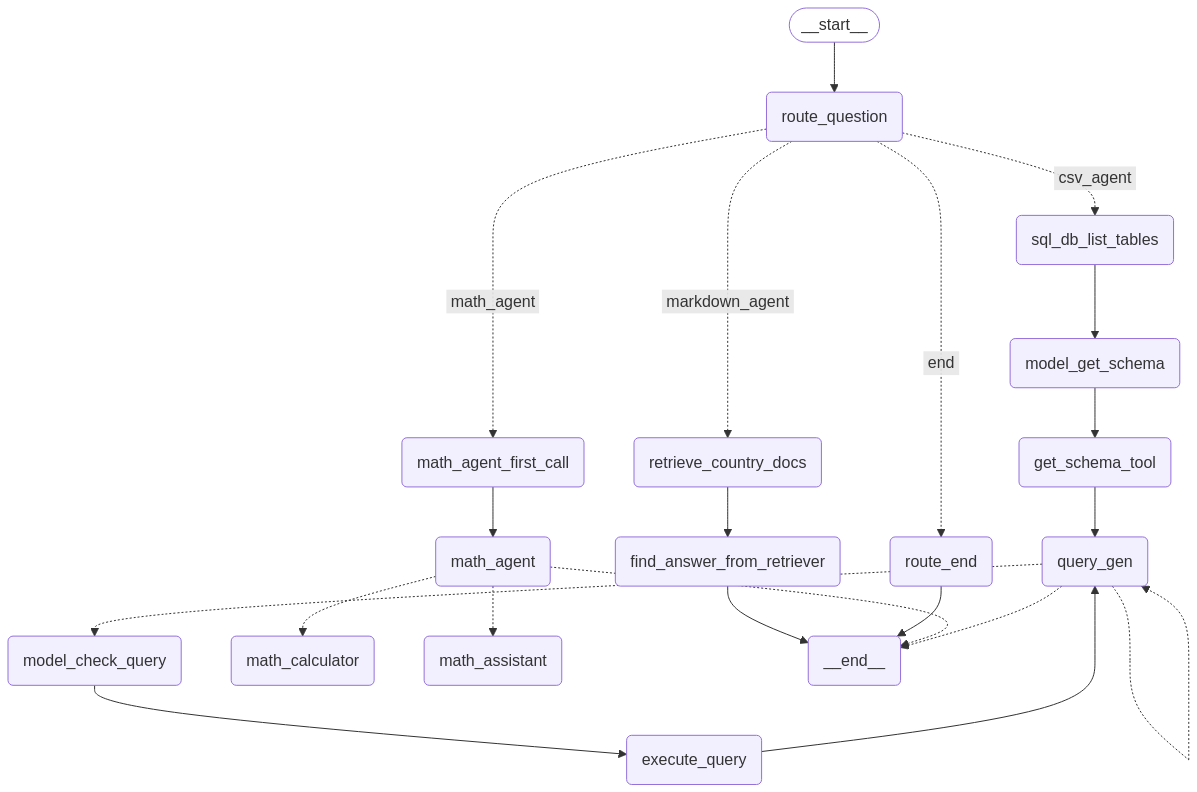

In [35]:
from IPython.display import Image, display
from langchain_core.runnables.graph import MermaidDrawMethod

image = Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
# Save the image
with open("./output_image.png", "wb") as f:
    f.write(image.data)
display(image)

# **Test Inference**

In [36]:
def invoke_query(question):
    messages = app.invoke(
    {"messages": [("human", question)]},
    )
    last_message = messages["messages"][-1]
    if getattr(last_message,"tool_calls", None):
        if last_message.tool_calls:
            json_str = last_message.tool_calls[0]["args"]["final_answer"]
        else:
            json_str = last_message.content
    else:
        json_str = last_message.content
    return json_str

### Query to Markdown data

In [37]:
question = "Tell me about Paris, Can you also tell about their famous play?"
print(invoke_query(question))

---ROUTE QUESTION---
--------- ROUTE COUNTRY VECTORSTORE ------
 ------ Retrieve Docs ------
Paris is the capital of Paris. Paris has a total area of 766045 square kilometers and a population of 85910809. Portuguese and English are the official languages spoken in the country. Many rivers flow through Paris. Paris's National Animal is the Giraffe and its National Bird is the Cardinal.  A famous play about Paris is  'The Merry Wives of Windsor' which involves a knight named Falstaff who tries to woo the wives of two wealthy citizens, but they trick him into hiding in a laundry basket and then as a fat woman. 


### Query to CSV/SQL data

In [41]:
question = "Tell the name of around 20 cars that were launched in 2025?"
print(invoke_query(question))

---ROUTE QUESTION---
--------- ROUTE SQL DATABASE ------
-------- Query Gen / SubmitFinalAnswer -------------
 ---- Verify Query ------
 ------- Inside model_check_query ----- 
-------- Query Gen / SubmitFinalAnswer -------------
 ---- Ending the graph --------
Here are some car names launched in 2025: OffDecision12, ExistGround23, SometimesHerself24, OffAround14, PriceIdea77, IndicateEarly62, FactSubject78, EverConsumer37, SpaceBillion33, OrganizationHope46, IssueAnything17, PushNight34.


#### Agent stream struggling to find the answer from **unstructured text** of a **csv Column**.
Here benefitial would be combining a retriever tool with sql agent so that results can be combiation of similarity search and sql results.

In [40]:
question = "What is the top speed of vehicles?"
for event in app.stream(
    {"messages": [("human", question)]},
    ):
    print(event)

---ROUTE QUESTION---
--------- ROUTE SQL DATABASE ------
{'route_question': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ymxe', 'function': {'arguments': '{"tool_input":""}', 'name': 'sql_db_list_tables'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 84, 'prompt_tokens': 2345, 'total_tokens': 2429, 'completion_time': 0.152727273, 'prompt_time': 0.080048278, 'queue_time': 0.162031291, 'total_time': 0.232775551}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1d176371-910e-4208-8c07-1610fb5bd695-0', tool_calls=[{'name': 'sql_db_list_tables', 'args': {'tool_input': ''}, 'id': 'call_ymxe', 'type': 'tool_call'}], usage_metadata={'input_tokens': 2345, 'output_tokens': 84, 'total_tokens': 2429})]}}
{'sql_db_list_tables': {'messages': [ToolMessage(content='cars', name='sql_db_list_tables', id='65e8bad5-52cc-4b4d-b5b6-416c6fe83ab3', tool_call_id

- Final answer given by agent is "**238 km/h**"

### Query to Math agent

In [30]:
question = "What is the probaility of tossing a coin?"
print(invoke_query(question))

---ROUTE QUESTION---
--------- MATH AGENT ------
-------- ROUTE MATH ASSISTANT ----------
The probability of tossing a coin is 1/2 or 50%. 



### Query not related to any provided data

In [26]:
question = "Do you know Psychology?"
print(invoke_query(question))

---ROUTE QUESTION---
--------- END the graph --------
The system can't provide answer to this question.
